In [ ]:
import nltk
import pandas as pd
import csv
import string
from textblob_de import TextBlobDE as TBD
from textblob import TextBlob as TBE
import spacy
import language_check
from scipy.spatial.distance import cdist
from laserembeddings import Laser
import kiwi
import utils

# Load pre-trained nlp models
sp_en = spacy.load("en")
sp_de = spacy.load("de")
en_checker = language_check.LanguageTool('en-GB')
ge_checker = language_check.LanguageTool('de-DE')

# Utils
def pos_parser(x,y):
    blacklist = ['.']
    x = [i.tag_ for i in x]
    x = {k:x.count(k) for k in x if k not in blacklist}
    y = [i.tag_ for i in y]
    y = {k:y.count(k) for k in y if k not in blacklist}
    if len(x)>len(y):
        it = x
        nit = y
    else:
        it = y
        nit = x
    res = 0
    for pos in it:
        if pos in nit:
            res += abs(it[pos]-nit[[pos]])
        else:
            res += it[pos]
    return res
def spacy_parser(x,y, mode='pos_'):
    # Models don't have the same entities
    whitelist = ['PER', 'PERSON', 'LOC', 'ORG']
    if mode in ['ents']:
        mode = 'label_'
        x = x.ents
        y = y.ents
    x = [getattr(i,mode) for i in x]
    x = {k:x.count(k) for k in x if k}
    y = [getattr(i, mode) for i in y]
    y = {k:y.count(k) for k in y if k}
    if mode in ['label_']:
        if 'PERSON' in x:
            x['PER'] = x.pop('PERSON')
        x = {k:v for k,v in x.items() if k in whitelist}
        y = {k:v for k,v in y.items() if k in whitelist}

    if len(x)>len(y):
        it = x
        nit = y
    else:
        it = y
        nit = x
    res = 0
    for pos in it:
        if pos in nit:
            res += abs(it[pos]-nit[pos])
        else:
            res += it[pos]
    return res

src = pd.read_csv('en-de/train.ende.src', sep="\n", error_bad_lines=False, quoting=csv.QUOTE_NONE, header=None)
target = pd.read_csv('en-de/train.ende.mt', sep="\n", error_bad_lines=False,quoting=csv.QUOTE_NONE, header=None)
scores = pd.read_csv('en-de/train.ende.scores', sep="\n", error_bad_lines=False,quoting=csv.QUOTE_NONE, header=None)
df = src.rename(columns={0:'src'})
df['tgt'] = target
# df = df.head(10)
# Remove punctuation
# df[['src_p', 'tgt_p']] = df[['src', 'tgt']].applymap(lambda x: x.lower().translate(str.maketrans('', '', string.punctuation)))
# # df['scores'] = scores
# df['src_len'] = df['src_p'].apply(lambda x: len(x.split(' ')))
# df['tgt_len'] = df['tgt_p'].apply(lambda x: len(x.split(' ')))
# df1 = pd.DataFrame({'src':[], 'tgt':[]}).transpose()
# df1['avg_tkn_len'] = df[['src_len', 'tgt_len']].mean().tolist()
# count = lambda l1,l2: sum([1 for x in l1 if x in l2])
# df['src_#punc'] = df['src'].apply(lambda x: count(x,set(string.punctuation)) )
# df['tgt_#punc'] = df['tgt'].apply(lambda x: count(x,set(string.punctuation)) )
# df['tgt_polar'] = df['tgt'].apply(lambda x: TBD(x).sentiment.polarity)
# df['src_polar'] = df['src'].apply(lambda x: TBE(x).sentiment.polarity)
# df['polar_dff'] = (df['tgt_polar']-df['src_polar']).abs()
# df['src_sp'] = df['src'].apply(lambda x: sp_en(x))
# df['tgt_sp'] = df['tgt'].apply(lambda x: sp_de(x))
# df['src_gram_err'] = df['src'].apply(lambda x: en_checker.check(x))
# df['tgt_gram_err'] = df['tgt'].apply(lambda x: ge_checker.check(x))
# df['sp_pos_diff'] = [spacy_parser(x,y, 'pos_') for x,y in zip(df['src_sp'], df['tgt_sp'])]
# df['sp_ent_diff'] = [spacy_parser(x,y, 'ents') for x,y in zip(df['src_sp'], df['tgt_sp'])]
# # Laser embeddings
# x = laser.embed_sentences(df['src'].tolist(), lang='en')
# y = laser.embed_sentences(df['tgt'].tolist(), lang='de')
# df['src_laser_embed'] = x.tolist()
# df['tgt_laser_embed'] = y.tolist()
# # Laser cosine distance
# for i in df.index:
#     df.loc[i, 'laser_embed_cdist'] = cdist(
#         np.array(df.loc[i, 'src_laser_embed']).reshape(1,-1),
#         np.array(df.loc[i, 'tgt_laser_embed']).reshape(1,-1),
#         'cosine')[0][0]
# # Openkiwi
# OK_url = 'https://github.com/unbabel/KiwiCutter/releases/download/v1.0/estimator_en_de.torch.zip'
# utils.download_kiwi(OK_url)
# model = kiwi.load_model('trained_models/estimator_en_de.torch/estimator_en_de.torch')
# examples = {'source': df['src'].tolist(),'target': df['tgt'].tolist()}
# predictions = model.predict(examples)
# df['openkiwi_score'] = predictions['sentence_scores']

# df['scores'] = scores

In [ ]:
df = pd.read_pickle('df.pkl')
df

In [ ]:
df.corr()

In [ ]:
import torch
xlmr = torch.hub.load('pytorch/fairseq', 'xlmr.large')


In [ ]:
import numpy as np


In [ ]:
# df.to_pickle('df.pkl')
# dist = cdist(x,y, 'cosine')

# for i in df.index:
#     df.loc[i, 'src_laser_embed'] = x[i]
# x.tolist()

In [ ]:
for i in df.index:
    df.loc[i, 'laser_embed_cdist'] = cdist(
        np.array(df.loc[i, 'src_laser_embed']).reshape(1,-1),
        np.array(df.loc[i, 'tgt_laser_embed']).reshape(1,-1),
        'cosine')[0][0]

In [ ]:
df['abs_laser_embed_cdist'] = df['laser_embed_cdist'].abs()

In [ ]:
import pandas as pd
df = pd.read_pickle('df.pkl')
# x = np.array(xlmr.encode('banana').tolist()).reshape(1,-1)
# y = np.array(xlmr.encode('vegetable').tolist()).reshape(1,-1)
# print(x, y)

In [ ]:
df.describe()

In [ ]:
from scipy.spatial.distance import cdist
from laserembeddings import Laser
laser = Laser()
embeddings = laser.embed_sentences(
    ['apple', 'légume'],
    lang=['en', 'fr'])
# cdist(x, y, 'cosine')
embeddings[0].shape

In [ ]:
df.columns
feats = [ 'src_len', 'tgt_len', 'src_#punc',
       'tgt_#punc', 'tgt_polar', 'src_polar',
       'src_gram_err', 'tgt_gram_err', 'sp_pos_diff', 'sp_ent_diff',
       'src_laser_embed', 'tgt_laser_embed']
res = df[feats]
res.to_pickle('feats.pkl')

In [ ]:
# res[['src_gram_err', 'tgt_gram_err']] = res[['src_gram_err', 'tgt_gram_err']].applymap(lambda x: len(x))
res

In [ ]:
cdist(embeddings[0].reshape(1,-1), embeddings[1].reshape(1,-1))
# embeddings = laser.embed_sentences(
#     ['let your neural network be polyglot',
#      'use multilingual embeddings!'],
#     lang='en')


In [ ]:
df.corr()

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(eng[0])

In [ ]:
import nltk
import pandas as pd
import csv
src = pd.read_csv('en-de/train.ende.src', sep="\n", error_bad_lines=False, quoting=csv.QUOTE_NONE, header=None).values
from laserembeddings import Laser
laser = Laser()
x = laser.embed_sentences(df['src'].tolist()[:5], lang='en')
y = laser.embed_sentences(df['tgt'].tolist()[:5], lang='de')

In [ ]:
import numpy as np
np.stack((x,y), axis=0).shape
np.concatenate((x,y),axis=1).shape

# Features

Sentiment analysis
Tense (future, past, present)
Grammatical sanity
possesive features (like Ludo<'s>)


In [ ]:
Do we assume english text to be accurate?
Approx same number of rules
English
Variants for: Australian, Canadian, GB, New Zealand, South African, US	2790
German
Variants for: Austria, Germany, Swiss	2894
http://wiki.languagetool.org/development-overview#toc0
    
preprocess by cleaning both texts of grammar.
import string
def preprocessing(lst):
    
    # Remove punctuation and lower-case
#     res = [i[0].lower().translate(str.maketrans('', '', string.punctuation)) for i in lst]
    # Remove stop words
    res = [i[0] for i in lst]
    return res
# eng = preprocessing(src)
# ger = preprocessing(target)

In [ ]:
mode = 'train'
src = pd.read_csv(f'en-de/{mode}.ende.src', sep="\n", error_bad_lines=False, quoting=csv.QUOTE_NONE, header=None)
target = pd.read_csv(f'en-de/{mode}.ende.mt', sep="\n", error_bad_lines=False,quoting=csv.QUOTE_NONE)
scores = pd.read_csv(f'en-de/{mode}.ende.scores', sep="\n", error_bad_lines=False,quoting=csv.QUOTE_NONE)
# df = src.rename(columns={0:'src'})
src

In [ ]:
ft = df.copy().iloc[:10]
ft[['src_p', 'tgt_p']] = ft[['src', 'tgt']].applymap(lambda x: x.lower().translate(str.maketrans('', '', string.punctuation)))
ft['src_len'] = ft['src_p'].apply(lambda x: len(x.split(' ')))
ft['tgt_len'] = ft['tgt_p'].apply(lambda x: len(x.split(' ')))
count = lambda l1,l2: sum([1 for x in l1 if x in l2])
ft['src_#punc'] = ft['src'].apply(lambda x: count(x,set(string.punctuation)) )
ft['tgt_#punc'] = ft['tgt'].apply(lambda x: count(x,set(string.punctuation)) )
ft['tgt_polar'] = ft['tgt'].apply(lambda x: TBD(x).sentiment.polarity)
ft['src_polar'] = ft['src'].apply(lambda x: TBE(x).sentiment.polarity)
ft['polar_ftf'] = (ft['tgt_polar']-ft['src_polar']).abs()
ft['src_sp'] = ft['src'].apply(lambda x: sp_en(x))
ft['tgt_sp'] = ft['tgt'].apply(lambda x: sp_de(x))
ft['src_gram_err'] = ft['src'].apply(lambda x: len(en_checker.check(x)))
ft['tgt_gram_err'] = ft['tgt'].apply(lambda x: len(ge_checker.check(x)))
ft['sp_pos_diff'] = [spacy_parser(x,y, 'pos_') for x,y in zip(ft['src_sp'], ft['tgt_sp'])]
ft['sp_ent_diff'] = [spacy_parser(x,y, 'ents') for x,y in zip(ft['src_sp'], ft['tgt_sp'])]
foi = [ 'src_len', 'tgt_len', 'src_#punc',
               'tgt_#punc', 'tgt_polar', 'src_polar',
               'src_gram_err', 'tgt_gram_err', 'sp_pos_diff', 'sp_ent_diff']
# def pos_parser(x,y):
#     blacklist = ['.']
#     x = [i.tag_ for i in x]
#     x = {k:x.count(k) for k in x if k not in blacklist}
#     y = [i.tag_ for i in y]
#     y = {k:y.count(k) for k in y if k not in blacklist}
#     if len(x)>len(y):
#         it = x
#         nit = y
#     else:
#         it = y
#         nit = x
#     res = 0
#     for pos in it:
#         if pos in nit:
#             res += abs(it[pos]-nit[[pos]])
#         else:
#             res += it[pos]
#     return res
# def spacy_parser(x,y, mode='pos_'):
#     # Models don't have the same entities
#     whitelist = ['PER', 'PERSON', 'LOC', 'ORG']
#     if mode in ['ents']:
#         mode = 'label_'
#         x = x.ents
#         y = y.ents
#     x = [getattr(i,mode) for i in x]
#     x = {k:x.count(k) for k in x if k}
#     y = [getattr(i, mode) for i in y]
#     y = {k:y.count(k) for k in y if k}
#     if mode in ['label_']:
#         if 'PERSON' in x:
#             x['PER'] = x.pop('PERSON')
#         x = {k:v for k,v in x.items() if k in whitelist}
#         y = {k:v for k,v in y.items() if k in whitelist}

#     if len(x)>len(y):
#         it = x
#         nit = y
#     else:
#         it = y
#         nit = x
#     res = 0
#     for pos in it:
#         if pos in nit:
#             res += abs(it[pos]-nit[pos])
#         else:
#             res += it[pos]
#     return res

from sklearn.preprocessing import Normalizer

# [i.pos_ for i in sp_en(df['src'][1])]
features = ft[foi].values
normalized_features = Normalizer().fit_transform(features)
# features
features

In [ ]:

import nltk
nltk.download('wordnet')# import torch
# x = torch.zeros(10,5)
# y = torch.zeros(10,10)
# torch.cat((x,y), dim=1).
x = np.load("saved_features/dev_nlp.npy", allow_pickle=True)
x.shape
pd.DataFrame(x).describe()
# from textblob_de import TextBlobDE as TBD
# from textblob import TextBlob as TBE
# scores = pd.read_csv('en-de/train.ende.src', sep="\n", error_bad_lines=False,quoting=csv.QUOTE_NONE, header=None)
# for j in range(1000):
#     x = scores[0][j]
#     sc1 = TBE(' '.join([i.lemmatize() for i in TBE(x).words])).polarity
#     sc2 = TBE(x).polarity
#     if sc1!=sc2:
#         print(sc1, sc2)
# x.describe()

In [ ]:
# For downloading language check need to install java8 and configure permissions
https://stackoverflow.com/questions/24342886/how-to-install-java-8-on-mac
https://github.com/myint/language-check/issues/59
https://github.com/myint/language-check/issues/31
https://stackoverflow.com/questions/40684543/how-to-make-python-use-ca-certificates-from-mac-os-truststore

In [511]:
from collections import namedtuple

import torch
from rosetta import RecursiveNN
import torch.utils.data as data_utils
import numpy as np
import pandas as pd

model = torch.load('model.pt')

In [512]:
import joblib
trainsc= np.load("saved_features/train_scores.npy", allow_pickle=True)

devnlp = np.load("saved_features/dev_nlp.npy", allow_pickle=True)
devlsr = np.load("saved_features/dev_lsr.npy", allow_pickle=True).reshape(-1,2048)
devsc= np.load("saved_features/dev_scores.npy", allow_pickle=True)
dev = namedtuple("res", ['lsr', 'feats', 'scores'])(
lsr=devlsr, feats=devnlp, scores=devsc)
dev_ = data_utils.TensorDataset(*[torch.tensor(getattr(dev, i)).float() for i in ['lsr', 'feats', 'scores']])
# dev_loader = data_utils.DataLoader(dev_, batch_size = hyperParams["batch_size_test"], shuffle = True)
with torch.no_grad():
    preds = model.forward(*dev_.tensors[:2]).cpu().numpy()
scaler = joblib.load('scaler.joblib')
# preds = scaler.inverse_transform(preds.reshape(-1,1)).ravel()

pd.DataFrame({'real':devsc, 'preds':preds}).corr()['preds']['real']

0.09230460440025988

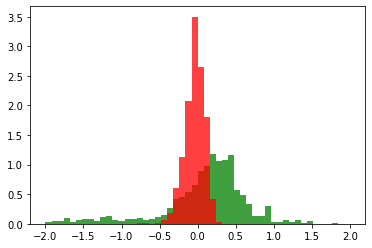

In [513]:
import matplotlib.pyplot as plt
%matplotlib inline
# n, bins, patches = plt.hist(scaler.inverse_transform(preds.reshape(-1,1)), 50,range=(-2,2), density=True, facecolor='g', alpha=0.75)
n, bins, patches = plt.hist(devsc, 50, density=True, facecolor='g', alpha=0.75, range=(-2,2))
n, bins, patches = plt.hist(preds, 50, density=True, facecolor='r', alpha=0.75, range=(-2,2))

# plt.plot(list(range(len(devsc))), np.sort(devsc))
plt.show()

In [301]:
trainsc= np.load("saved_features/train_scores.npy", allow_pickle=True)

n, bins, patches = plt.hist(scaler.inverse_transform(preds), 50, density=True,range=(-2, 2), facecolor='g', alpha=0.75)

# plt.plot(list(range(len(devsc))), np.sort(devsc))
# plt.savefig('imbalanced.eps')
plt.show()

ValueError: Expected 2D array, got 1D array instead:
array=[0.20404603 0.20564424 0.16887094 0.17042914 0.1794595  0.2382366
 0.11353332 0.25966322 0.20991327 0.13521901 0.20259239 0.321162
 0.22557347 0.22297268 0.19071202 0.17830004 0.14524971 0.16705436
 0.2248046  0.23442186 0.19971547 0.08021262 0.17555457 0.2715661
 0.13915639 0.1810096  0.20739357 0.19478059 0.17568716 0.1596676
 0.11125122 0.19698195 0.24130344 0.2239587  0.11302398 0.15329665
 0.13214374 0.06047789 0.2706148  0.18485191 0.22723626 0.15269013
 0.20344625 0.2712228  0.20212431 0.10860084 0.12763306 0.21325289
 0.1904584  0.1772421  0.26502597 0.09080613 0.2369362  0.19669542
 0.24877414 0.16232559 0.252643   0.06034855 0.22758998 0.21134241
 0.11812332 0.25287202 0.18725507 0.17298146 0.18128724 0.0915978
 0.12637833 0.09537728 0.24288392 0.2254853  0.18203135 0.14351428
 0.1550997  0.02560772 0.17075104 0.21485381 0.23990285 0.24883705
 0.27663812 0.19441518 0.12545204 0.10829307 0.16730861 0.23354062
 0.2463279  0.15924625 0.18443018 0.18076338 0.24342795 0.1359428
 0.15875365 0.11297727 0.23059131 0.1545763  0.17036363 0.22174364
 0.24541816 0.14210165 0.21868478 0.16846946 0.21068059 0.20592128
 0.20145227 0.11021566 0.18908893 0.19363852 0.20588247 0.18392953
 0.21296301 0.18460058 0.21058185 0.22841623 0.20703606 0.21317086
 0.25888345 0.24391873 0.17019095 0.23021863 0.2470289  0.07026623
 0.26170352 0.07885037 0.27564713 0.19897448 0.26570183 0.14576627
 0.1063261  0.13493346 0.24089617 0.15584005 0.28388733 0.20039107
 0.24700458 0.16490601 0.17474116 0.19117662 0.1938437  0.1767102
 0.1813294  0.20340809 0.22015344 0.20165245 0.22666268 0.09075367
 0.23691843 0.1676609  0.18318501 0.19080906 0.23026486 0.25521407
 0.22264527 0.16068333 0.14242423 0.16786443 0.25024676 0.14971264
 0.32132447 0.19146587 0.14222677 0.22090027 0.20523569 0.18313415
 0.25549176 0.20408466 0.2158335  0.20058794 0.23877294 0.14835581
 0.17236516 0.21318078 0.24637726 0.29249278 0.16260904 0.19859745
 0.18495242 0.17208569 0.19642012 0.22012326 0.19829226 0.19313775
 0.16219646 0.20425548 0.2048728  0.23469235 0.1793815  0.23019384
 0.2935493  0.07300865 0.19610073 0.18097109 0.00790757 0.21367212
 0.16516325 0.20520848 0.21699756 0.17540978 0.20598596 0.22296584
 0.24215482 0.24543199 0.20295969 0.1387581  0.21599782 0.1646709
 0.20446911 0.0686598  0.27510682 0.17753492 0.21064915 0.16761582
 0.19812551 0.10388574 0.18162112 0.14806902 0.16231029 0.15816537
 0.09693918 0.12358455 0.18595311 0.21239671 0.151792   0.11114314
 0.2460311  0.21804564 0.26118243 0.20889594 0.10133857 0.20339476
 0.15635237 0.24827632 0.27337113 0.22904304 0.20143606 0.18454038
 0.20476057 0.2607682  0.16394281 0.19605626 0.17681395 0.1612929
 0.30561405 0.2833596  0.21456958 0.17296994 0.18900031 0.13013245
 0.21339615 0.16962941 0.16951895 0.18371442 0.13076067 0.20049277
 0.13933875 0.18483621 0.22454178 0.14373925 0.19349408 0.20604998
 0.18687914 0.17763665 0.23442528 0.15262492 0.17571607 0.3033399
 0.23230527 0.21903676 0.2466985  0.2154236  0.21432649 0.24114846
 0.21454991 0.20963486 0.14250556 0.17756605 0.230167   0.17206052
 0.19700807 0.2486921  0.22082756 0.25356677 0.1655583  0.25393525
 0.25594434 0.19773184 0.18083645 0.20716453 0.19263922 0.21344313
 0.26559502 0.15691495 0.16034064 0.20297606 0.2775865  0.07388406
 0.2652426  0.1825696  0.2002343  0.2135111  0.06186917 0.20423648
 0.16835363 0.2059356  0.21668993 0.10108845 0.23150156 0.23510592
 0.26370966 0.13556099 0.21419047 0.20287529 0.16416447 0.14717129
 0.21929851 0.09007473 0.14590777 0.22246101 0.26600516 0.06970257
 0.20902915 0.1716519  0.12401468 0.03807907 0.19229744 0.20887108
 0.120764   0.23556952 0.15156813 0.09355687 0.20028718 0.27877447
 0.24214005 0.12735032 0.25658986 0.2039558  0.20140381 0.2206623
 0.16320434 0.1704479  0.2194303  0.1469027  0.12802452 0.10600407
 0.18690635 0.23631462 0.23560804 0.16869734 0.18025383 0.27352765
 0.18100516 0.29641747 0.30224934 0.15375292 0.2365125  0.16756476
 0.195457   0.07141192 0.13494018 0.11238544 0.18928413 0.08783369
 0.17111225 0.1788484  0.2706747  0.06926498 0.22469905 0.2531952
 0.18917726 0.2242226  0.29567078 0.26018023 0.24948387 0.11830172
 0.2088154  0.15557092 0.17111762 0.15949538 0.24089882 0.1863816
 0.23737447 0.16545539 0.25320315 0.15151113 0.26012608 0.14961475
 0.28284788 0.18706441 0.22694758 0.26845795 0.13024989 0.23913403
 0.23679383 0.26061213 0.1249354  0.17953    0.17291789 0.16323838
 0.10675456 0.1726927  0.17502038 0.22521657 0.23721308 0.19446899
 0.13656151 0.24557681 0.17525913 0.24403086 0.1921676  0.21044631
 0.25743434 0.1967097  0.3023366  0.29481867 0.2013618  0.21601741
 0.22124462 0.15666395 0.11173891 0.17442504 0.2601527  0.09634197
 0.15163945 0.29777056 0.22540486 0.15414919 0.27272367 0.09813263
 0.15604907 0.11683042 0.2516289  0.16710636 0.14945914 0.12049174
 0.06218096 0.19781156 0.15364334 0.27999574 0.16080217 0.11253251
 0.25265715 0.24016228 0.2339958  0.13350633 0.21213502 0.1259435
 0.11914103 0.20322506 0.2516784  0.15609758 0.18903394 0.22702883
 0.09276958 0.18857346 0.2104723  0.25086087 0.08098357 0.17094874
 0.08130471 0.25652152 0.20948072 0.0577866  0.22308092 0.2385469
 0.15492235 0.18507318 0.18867558 0.21496409 0.1877563  0.13491565
 0.16101292 0.15165713 0.25527897 0.13393196 0.18063419 0.19017705
 0.13906763 0.17322375 0.15960404 0.16696306 0.21590473 0.17172545
 0.14526819 0.15478876 0.3072429  0.21131504 0.14490129 0.1964142
 0.09525403 0.20584145 0.17371339 0.14137144 0.237      0.04404913
 0.17728393 0.18032743 0.20965247 0.1833688  0.22978568 0.22239722
 0.16585886 0.22216263 0.1965556  0.24830602 0.12495318 0.18934041
 0.23106654 0.22079633 0.15701704 0.21226639 0.24227972 0.23903729
 0.19300686 0.12828285 0.18736011 0.11053179 0.19642054 0.22504596
 0.29966936 0.19777459 0.18108939 0.14494146 0.19855355 0.12155277
 0.19223791 0.15875763 0.17464103 0.23361818 0.23151776 0.13328077
 0.16819194 0.13902432 0.16487722 0.21076712 0.13304886 0.0915034
 0.19219814 0.10983343 0.22928455 0.14801578 0.21013421 0.1542959
 0.27624065 0.19340232 0.15137608 0.228515   0.26028866 0.2057941
 0.25835937 0.25908437 0.18212686 0.2370762  0.09605204 0.29337513
 0.229759   0.22456145 0.29046524 0.2466511  0.20751949 0.1961389
 0.18542503 0.26354477 0.16145965 0.11061805 0.31941923 0.25420386
 0.2786446  0.12494099 0.18910238 0.21149687 0.17368165 0.22005211
 0.19030212 0.12891544 0.2131017  0.12517531 0.15632272 0.20988014
 0.21803428 0.23219885 0.15598339 0.3168611  0.1582334  0.1130587
 0.25375038 0.16281377 0.1793921  0.30369234 0.12075095 0.21300961
 0.22026299 0.17347825 0.20403017 0.19078152 0.21251106 0.18117796
 0.20695826 0.24094509 0.22705443 0.15171646 0.19390681 0.23843913
 0.16738869 0.18326247 0.15612243 0.23775092 0.15980573 0.27573818
 0.26661354 0.22415099 0.2084913  0.17819941 0.16866632 0.2073609
 0.13271557 0.15022895 0.16995583 0.17415163 0.20192368 0.12873995
 0.16736473 0.19697209 0.1491087  0.28432626 0.20467594 0.22660188
 0.21260898 0.28627822 0.19934632 0.16533436 0.1053008  0.14709854
 0.21216151 0.26855218 0.23222719 0.2658687  0.13904376 0.2355328
 0.23268975 0.23325652 0.2295201  0.19315173 0.30968487 0.227975
 0.14296421 0.10004756 0.19278915 0.22019887 0.10981424 0.17579831
 0.2415363  0.25250524 0.21641953 0.11881739 0.17402531 0.15107086
 0.19369075 0.14618888 0.06412484 0.1628021  0.14263366 0.23205763
 0.22056028 0.20614517 0.15826277 0.22387803 0.19417015 0.19403923
 0.24383436 0.18384926 0.22136343 0.1934512  0.17566426 0.24760365
 0.06132841 0.1317008  0.2984214  0.18771257 0.20636083 0.20369162
 0.20670609 0.25686613 0.0507447  0.219813   0.20169757 0.23676044
 0.12264396 0.2409289  0.23205028 0.15678698 0.20479791 0.25095648
 0.11985435 0.21397826 0.26185563 0.17726965 0.18982801 0.07988742
 0.19619031 0.22132963 0.17091353 0.24108917 0.25504932 0.14877973
 0.24607989 0.2022863  0.18326144 0.20425819 0.1748468  0.17928867
 0.23111938 0.13300559 0.18238984 0.21383013 0.22175118 0.14584172
 0.04754949 0.21156757 0.18970229 0.15705118 0.10871561 0.28485793
 0.12960538 0.17315774 0.17362808 0.21242675 0.21489666 0.14992484
 0.19389819 0.19407497 0.23817126 0.15167163 0.16074799 0.2156024
 0.15951608 0.3282218  0.11585614 0.13276574 0.18847057 0.13967143
 0.10325952 0.25996998 0.24296612 0.18770798 0.15829773 0.20212623
 0.15563592 0.19203852 0.22607994 0.25183332 0.21226503 0.12553243
 0.2174251  0.1491661  0.2136831  0.1557196  0.2005872  0.220233
 0.2121587  0.08315009 0.216399   0.1479201  0.19201298 0.21626042
 0.19605674 0.18939905 0.17806497 0.20247506 0.23723055 0.20950694
 0.20512529 0.2617135  0.10996713 0.11264496 0.22106235 0.02157198
 0.21284804 0.23826598 0.19135137 0.21321148 0.15721914 0.1972481
 0.14805064 0.19520798 0.21467632 0.14921665 0.27928954 0.17199746
 0.20365334 0.18570104 0.11601129 0.18295641 0.17001392 0.205683
 0.16852002 0.15351315 0.13196896 0.10175218 0.09918396 0.16302028
 0.20690972 0.22984912 0.23736052 0.14077061 0.16302451 0.21324322
 0.23855114 0.26670757 0.16867878 0.30137956 0.18656538 0.2041034
 0.17861117 0.11448833 0.21037763 0.10881926 0.26187935 0.2887726
 0.15133826 0.19225025 0.22329953 0.14997843 0.1907825  0.17266437
 0.2274645  0.1915077  0.21115063 0.21611728 0.08320729 0.20940846
 0.1148863  0.08029667 0.19978999 0.19178376 0.28737742 0.21171708
 0.2523113  0.12629299 0.15252765 0.14694385 0.14717953 0.21664028
 0.29988804 0.17570883 0.22615698 0.25806075 0.12643732 0.23344809
 0.15746853 0.2601666  0.2529036  0.15061548 0.14206222 0.26282465
 0.16208631 0.1634554  0.12014867 0.21966286 0.16919038 0.19768155
 0.21940504 0.12243539 0.21646632 0.22094439 0.18616515 0.21059032
 0.15555917 0.11421528 0.15243292 0.14061686 0.24425675 0.16321953
 0.25072253 0.16626596 0.0977089  0.22285932 0.2479815  0.20680271
 0.22682452 0.19581993 0.22576372 0.15800776 0.19600998 0.20937905
 0.19802013 0.13619357 0.13574915 0.17414896 0.17596011 0.15666237
 0.07993762 0.17922221 0.0861682  0.20325856 0.12154423 0.1674727
 0.19889814 0.1893511  0.2423177  0.21638437 0.18040651 0.1640543
 0.12108502 0.00539426 0.27948838 0.19832565 0.22370425 0.24918975
 0.169694   0.23357075 0.19551338 0.22892903 0.21368119 0.19806346
 0.1993799  0.1839516  0.2014801  0.24868745 0.1890938  0.20620717
 0.17039058 0.21687488 0.11665133 0.24600421 0.31350625 0.16696195
 0.24499401 0.23781829 0.10570484 0.0937831  0.24715881 0.26736042
 0.24129926 0.12724411 0.1392129  0.24712487 0.18635674 0.1443318
 0.1923665  0.20473216 0.20670256 0.10220125 0.17063497 0.22981948
 0.2339044  0.25495574 0.18604203 0.25878713 0.1381443  0.18782753
 0.13077587 0.21323541 0.07509476 0.17069787 0.18416916 0.23518766
 0.12592854 0.20834698 0.15365693 0.18025292 0.25240538 0.19567217
 0.21367012 0.15491484 0.21833777 0.19121541 0.24029973 0.19216949
 0.06563167 0.19142056 0.2402683  0.13649163 0.22900271 0.22425278
 0.3162199  0.07333682 0.14797662 0.17724797 0.11648832 0.20020248
 0.15276615 0.19442852 0.2638461  0.23254074 0.23708479 0.18997814
 0.13905174 0.17626305 0.05424624 0.19614077 0.17026652 0.22612616
 0.22378495 0.24470796 0.26155925 0.24588342 0.21502337 0.13562919
 0.23408125 0.02811525 0.23226328 0.20714235].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

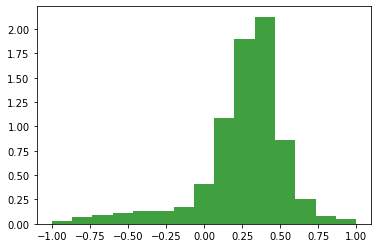

In [305]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
devsc= np.load("saved_features/dev_scores.npy", allow_pickle=True).reshape(-1,1)
trainsc = np.load("saved_features/train_scores.npy", allow_pickle=True).reshape(-1,1)
# devsc=trainsc
ss = MinMaxScaler((-1,1))
# ss = StandardScaler()

# trainsc[trainsc>-2].reshape(-1,1)
train_filtered = trainsc[(trainsc<1.6)&(trainsc>-2.5)].reshape(-1,1)
ss.fit(train_filtered)
scaled_train = ss.transform(train_filtered)

n, bins, patches = plt.hist(scaled_train, 15, density=True,range=(-1, 1), facecolor='g', alpha=0.75)

prob_dist = np.ones(len(n))-n*0.45
prob_dist = prob_dist/sum(prob_dist)
# plt.plot()
# plt.ylim(0,0.15)
plt.show()
# plt.savefig('scaled_train.eps')

# plt.show()


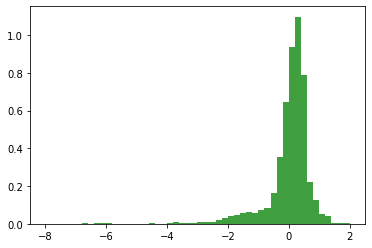

In [251]:
n, bins, patches = plt.hist(trainsc, 50, density=True,range=(-8, 2), facecolor='g', alpha=0.75)
plt.show()

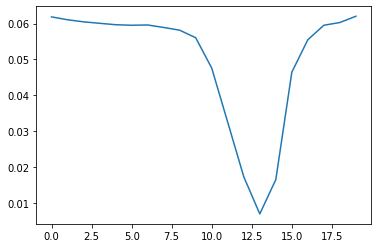

In [284]:

plt.plot(prob_dist)
plt.show()

In [253]:
min(scaled_train)

array([-1.])

In [254]:
np.nonzero(trainsc.ravel()>-2)

(array([   0,    1,    3, ..., 6997, 6998, 6999]),)

In [255]:
len(train_filtered)

6866

In [256]:
trainsc.shape

(7000, 1)

In [257]:
np.mean(scaled_train)

0.25614693680809086

In [258]:
np.nonzero((trainsc.ravel()<1.6)&(trainsc.ravel()>-2.5))

(array([   0,    1,    2, ..., 6997, 6998, 6999]),)

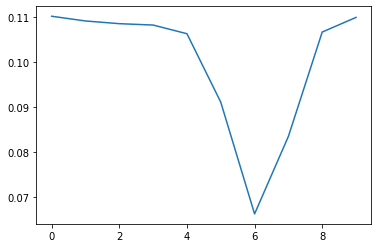

In [274]:
plt.plot(prob_dist)

In [269]:
p

array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ])

In [306]:
probs = np.ones(len(scaled_train))
scaled_train = scaled_train.ravel()
for idx in range(len(bins)-1):
    probs[(scaled_train>bins[idx])&(scaled_train<bins[idx+1])] = 1*prob_dist[idx]
scaled_probs = probs/sum(probs)


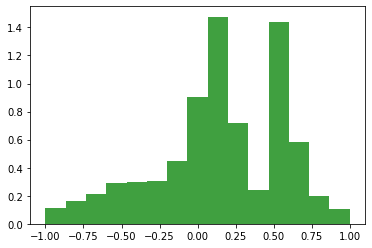

In [307]:
x = np.random.choice(scaled_train, p=scaled_probs, size=len(scaled_train)+3000)
n, bins, patches = plt.hist(x, 15, density=True,range=(-1, 1), facecolor='g', alpha=0.75)
plt.show()



In [389]:
np.concatenate([np.zeros((4,5)),np.ones((3,5))],axis=0).shape

(7, 5)

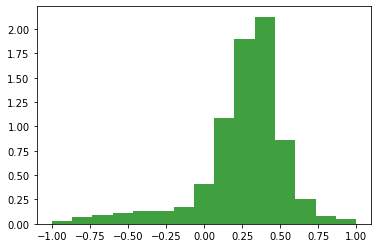

In [487]:
nlp = np.load("saved_features/train_nlp.npy", allow_pickle=True)
lsr = np.load("saved_features/train_lsr.npy", allow_pickle=True).reshape(-1,2048)
scores = np.load("saved_features/train_scores.npy", allow_pickle=True)
scores = scores.reshape(-1,1)

idxs = np.nonzero((scores.ravel()<1.6)&(scores.ravel()>-2.5)) # Get indices to keep
filtered_lsr = lsr[idxs]
filtered_nlp = nlp[idxs]
filtered_scores = scores[idxs]

scaler = MinMaxScaler((-1,1))
scaler.fit(filtered_scores)
scaled_scores = scaler.transform(filtered_scores)

n, bins, patches = plt.hist(scaled_scores, 15, density=True, range=(-1, 1), facecolor='g', alpha=0.75)

prob_dist = np.ones(len(n))-n*0.45
prob_dist = prob_dist**15/sum(prob_dist)

# dump(self.scaler, 'scaler.joblib')

probs = np.ones(len(scaled_scores))
scaled_scores = scaled_scores.ravel()
for idx in range(len(bins)-1):
    probs[(scaled_scores>bins[idx])&(scaled_scores<bins[idx+1])] = 1*prob_dist[idx]
scaled_probs = probs/sum(probs)

idxs = np.random.choice(list(range(len(scaled_scores))), p=scaled_probs, size=6000)

augmented_lsr = np.zeros((len(idxs), lsr.shape[1]))
augemented_nlp = np.zeros((len(idxs), nlp.shape[1]))
augmented_scores = np.zeros((len(idxs), scores.shape[1]))
lsr_std = filtered_lsr.std(axis=0)
nlp_std = filtered_nlp.std(axis=0)
scores_std = filtered_scores.std(axis=0)
for i, value in enumerate(idxs):
    augmented_lsr[i,:] = filtered_lsr[value, :]+ np.random.normal(0, lsr_std*0.05, lsr.shape[1])
    augemented_nlp[i,:] = filtered_nlp[value, :]+ np.random.normal(0, nlp_std*0.05, nlp.shape[1])
    augmented_scores[i,:] = filtered_scores[value, :]+ np.random.normal(0, scores_std*0.05, scores.shape[1])

final_lsr = np.concatenate([filtered_lsr, augmented_lsr],axis=0)
final_nlp = np.concatenate([filtered_nlp, augemented_nlp],axis=0)
final_scores = np.concatenate([filtered_scores, augmented_scores],axis=0)

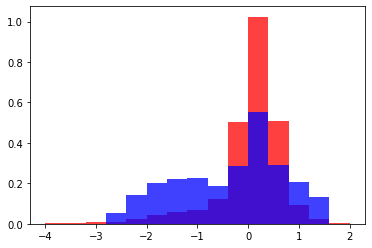

In [488]:
n, bins, patches = plt.hist(scores, 15, density=True, range=(-4, 2), facecolor='r', alpha=0.75)
n, bins, patches = plt.hist(final_scores, 15, density=True,range=(-4, 2), facecolor='b', alpha=0.75)


In [480]:
final_scores.shape

(12866, 1)